# Bayes Opt Hacking

In [4]:
%load_ext autoreload
%autoreload 2
from belief_active_plot import BeliefActivePlot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Running functions
args = {
    'net': 'VariationalGaussianProcessRegressor',
    'architecture': ['GraphSAGE', '32', 'activation', 'tanh',
                     'GraphSAGE', '32', 'activation', 'tanh',
                     'GraphSAGE', '32', 'activation', 'tanh'],
    'optimizer': 'Adam', # Adam
    'lr': 1e-4,
    'data': 'mpro_hts', # moonshot_sorted
    'strategy': 'sequential',
    'acquisition': 'Random', # ExpectedImprovement
    'num_thompson_samples': 1000,
    'num_samples': 1000,
    'q': 96,
    'device': 'cuda:0',
    'num_trials': 1, # 9
    'num_rounds': 15, # 80
    'num_epochs': 250, # 200
    'index_provided': True,
    'early_stopping': False,
    'beliefs': [],
    'annealing': 1.0,
    'n_inducing_points': 100,
    'sample_frac': 0.25, # 1.0
    'update_representation_interval': 20,
}

from types import SimpleNamespace
args = SimpleNamespace(**args)

plot = BeliefActivePlot(
    # net config
    net=args.net,
    architecture=args.architecture,
    n_inducing_points=args.n_inducing_points,
    annealing=args.annealing,

    # optimizer config
    optimizer_type=args.optimizer,
    lr=args.lr,

    # experiment config
    data=args.data,
    sample_frac=args.sample_frac,
    acquisition=args.acquisition,
    num_samples=args.num_samples,
    num_thompson_samples=args.num_thompson_samples,        
    q=args.q,
    early_stopping=args.early_stopping,

    # beliefs
    beliefs=args.beliefs,

    # housekeeping
    device=args.device,
    num_trials=args.num_trials,
    num_rounds=args.num_rounds,
    num_epochs=args.num_epochs,
    update_representation_interval=args.update_representation_interval
)

In [3]:
best_df = plot.generate()

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [6]:
ds = plot.generate_data()

In [7]:
import numpy as np
dist = np.array([d[1].item() for d in ds])

In [90]:
from tqdm import tqdm

num_rounds = 20
num_trials = 100
samples = []
for trial in tqdm(range(num_trials)):
    seen, unseen = list(), list(range(len(dist)))
    for r in range(num_rounds):
        pending = np.random.choice(list(unseen), size=96, replace=False)
        seen.extend(pending)
        (unseen.remove(p) for p in pending)
        samples.append(
            {
                'Best Value': max(dist[seen]),
                'Round': r,
                'Trial': trial
            }
        )

100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 12.60it/s]


Text(0.5, 1.0, 'HTS 10uM Mpro fractional inhibition distribution')

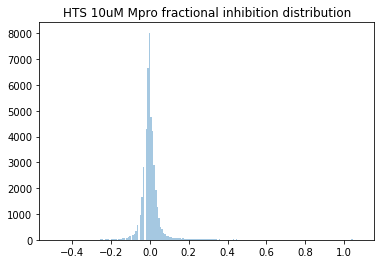

In [97]:

sns.distplot(dist[dist > -0.5], bins=200, kde=None)
plt.title('HTS 10uM Mpro fractional inhibition distribution')

In [95]:
best = pd.DataFrame(samples)
prob_hits = []
for r in range(num_rounds-1):
    round_best_hits = (best.query(f'Round == {r}')['Best Value'] > 0.9)
    prob_find_hit = round_best_hits.sum() / len(round_best_hits)
    prob_hits.append(
        {
            'Round': r,
            'Empirical Pr of Hit': prob_find_hit,
            'Datapoints Acquired': r*96,
            'Strategy': 'Random'
        }
    )

In [96]:
pd.DataFrame(prob_hits)

,Round,Empirical Pr of Hit,Datapoints Acquired,Strategy
0,0,0.16,0,Random
1,1,0.32,96,Random
2,2,0.39,192,Random
3,3,0.52,288,Random
4,4,0.62,384,Random
5,5,0.70,480,Random
6,6,0.76,576,Random
7,7,0.81,672,Random
8,8,0.84,768,Random
9,9,0.88,864,Random


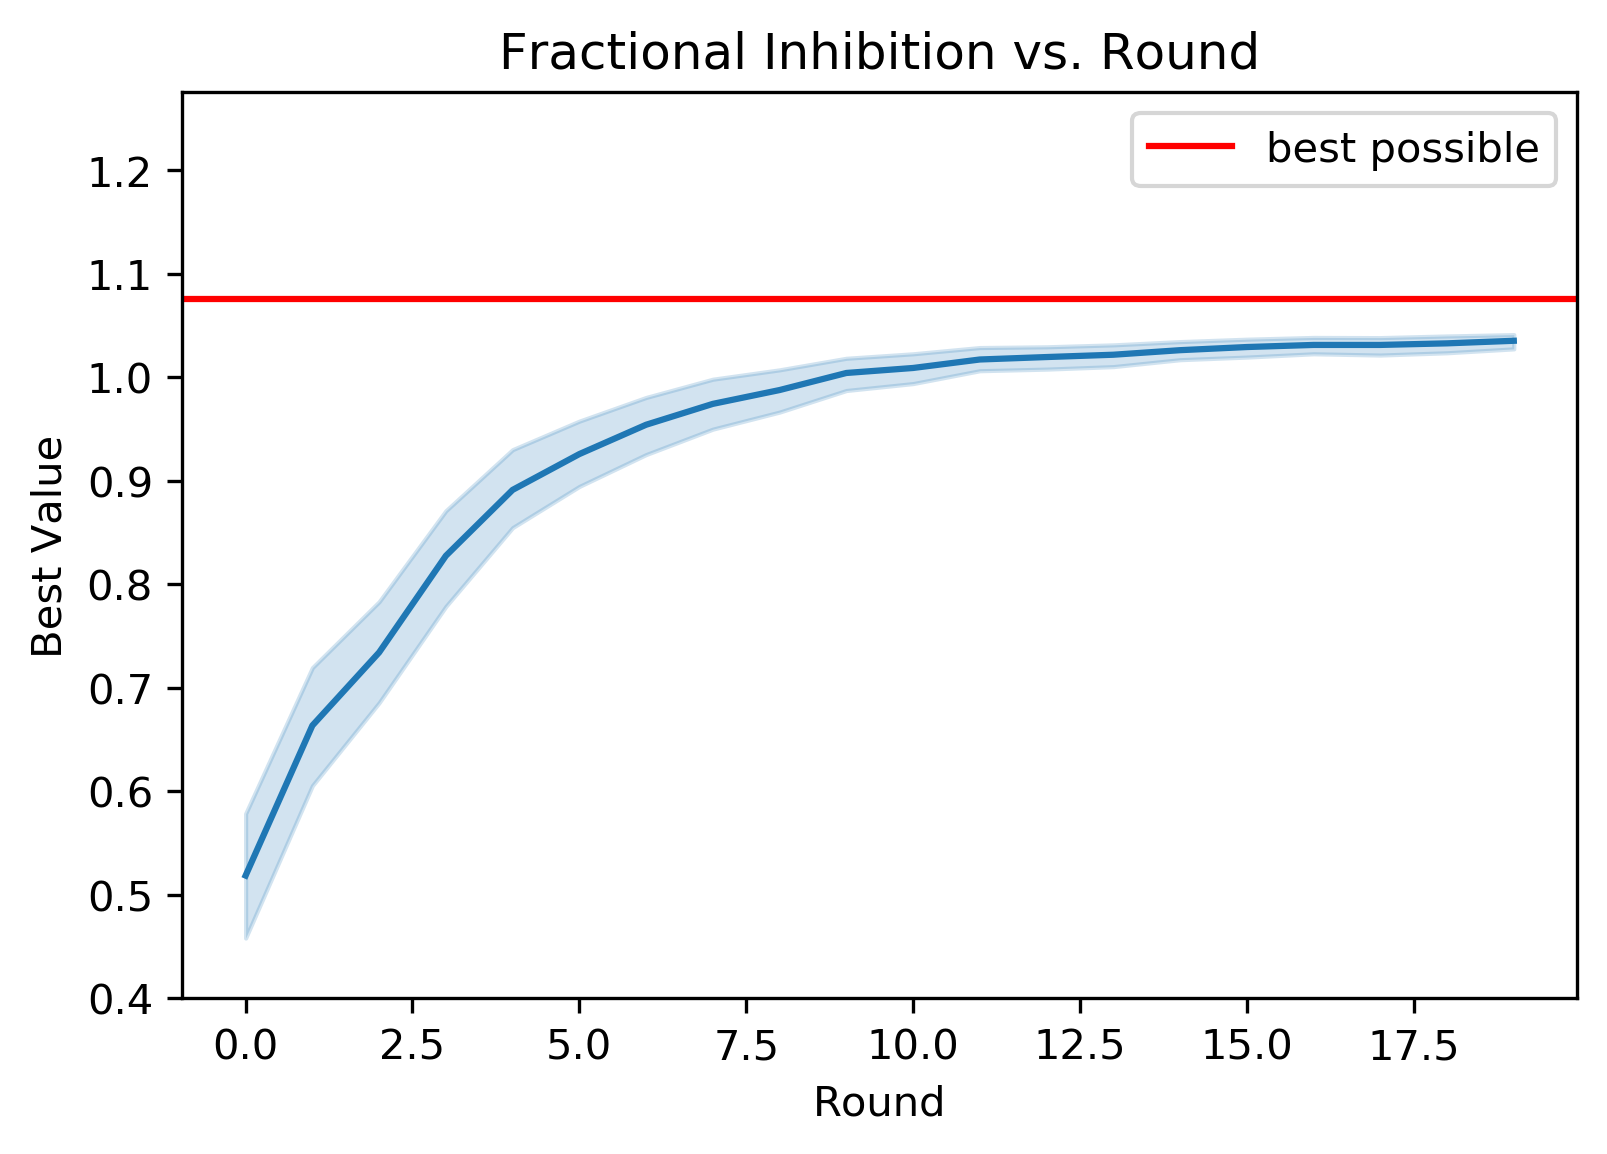

In [98]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
    
best = pd.DataFrame(samples)

fig, ax = plt.subplots(dpi=300)

sns.lineplot(
    data=best,
    x='Round',
    y='Best Value',
    ax=ax
)

ax.set_title('Fractional Inhibition vs. Round')
ax.axhline(max(dist), color='red', label='best possible')
ax.set_ylim(0.4, max(dist)+0.2)
plt.legend()